In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<h1>Building the Tables</h1>

<p>We've done the major preprocessing in other scripts, and now it's time to get our final tables together for fielders, catchers and pitchers with all appropriate stats.</p>

In [2]:
df_bat = pd.read_csv('../core/output/batting_pre.csv')
df_field = pd.read_csv('../core/output/fielding_pre.csv')
df_catch = pd.read_csv('../core/output/catching_pre.csv')
df_pitch = pd.read_csv('../core/output/pitching_pre.csv')
df_meta = pd.read_csv('../core/output/metadata.csv')

In [3]:
df_meta.head()

,retroID,POS,birthYear,bats,throws,weight,height
0,aardd001,P,1981.0,R,R,215.0,75.0
1,aaroh101,OF,1934.0,R,R,180.0,72.0
2,aarot101,1B,1939.0,R,R,190.0,75.0
3,aased001,P,1954.0,R,R,190.0,75.0
4,abada001,1B,1972.0,L,L,184.0,73.0


<h3>Making Metadata Usable</h3>

<p>We are interested in all of these fields, so we want to convert POS, bats and throws to numbers and use dummy variables. Note that we won't be using birthYear as-is, but rather subtracting it from current year to get a player's age for a season. This won't matter for the player career stats tensor so we can drop it here.</p>

In [4]:
df_meta.drop(columns=['birthYear'], inplace=True)

In [5]:
df_meta_pos = pd.get_dummies(df_meta['POS'], prefix='pos')
df_meta_bats = pd.get_dummies(df_meta['bats'], drop_first=True, prefix='bats')
df_meta_throws = pd.get_dummies(df_meta['throws'], prefix='throws')

In [6]:
dropped_meta_cols = ['POS', 'bats', 'throws']
df_meta.drop(columns=dropped_meta_cols, inplace=True)
df_meta.head()

,retroID,weight,height
0,aardd001,215.0,75.0
1,aaroh101,180.0,72.0
2,aarot101,190.0,75.0
3,aased001,190.0,75.0
4,abada001,184.0,73.0


In [7]:
df_meta = df_meta.join([df_meta_pos, df_meta_bats, df_meta_throws])
df_meta

,retroID,weight,height,pos_1B,pos_2B,pos_3B,pos_C,pos_OF,pos_P,pos_SS,bats_L,bats_R,throws_L,throws_R,throws_S
0,aardd001,215.0,75.0,0,0,0,0,0,1,0,0,1,0,1,0
1,aaroh101,180.0,72.0,0,0,0,0,1,0,0,0,1,0,1,0
2,aarot101,190.0,75.0,1,0,0,0,0,0,0,0,1,0,1,0
3,aased001,190.0,75.0,0,0,0,0,0,1,0,0,1,0,1,0
4,abada001,184.0,73.0,1,0,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15026,zupcb001,220.0,76.0,0,0,0,0,1,0,0,0,1,0,1,0
15027,zupof101,182.0,71.0,0,0,0,1,0,0,0,1,0,0,1,0
15028,zuveg101,195.0,76.0,0,0,0,0,0,1,0,0,1,0,1,0
15029,zuvep001,173.0,72.0,0,0,0,0,0,0,1,0,1,0,1,0


<p>I didn't drop_first on the 'throws_' columns because I want to get rid of 'throws_S' instead of 'throws_L'</p>

In [8]:
df_meta.drop(columns=['throws_S'], inplace=True)

<p>We want to use weight and height but we can normalize them</p>

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler()

In [11]:
df_meta[['weight', 'height']] = scaler.fit_transform(df_meta[['weight', 'height']])
df_meta

,retroID,weight,height,pos_1B,pos_2B,pos_3B,pos_C,pos_OF,pos_P,pos_SS,bats_L,bats_R,throws_L,throws_R
0,aardd001,0.569672,0.60,0,0,0,0,0,1,0,0,1,0,1
1,aaroh101,0.426230,0.45,0,0,0,0,1,0,0,0,1,0,1
2,aarot101,0.467213,0.60,1,0,0,0,0,0,0,0,1,0,1
3,aased001,0.467213,0.60,0,0,0,0,0,1,0,0,1,0,1
4,abada001,0.442623,0.50,1,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15026,zupcb001,0.590164,0.65,0,0,0,0,1,0,0,0,1,0,1
15027,zupof101,0.434426,0.40,0,0,0,1,0,0,0,1,0,0,1
15028,zuveg101,0.487705,0.65,0,0,0,0,0,1,0,0,1,0,1
15029,zuvep001,0.397541,0.45,0,0,0,0,0,0,1,0,1,0,1


<p>The metadata is now ready to go into the final tensor.</p>

<h2>Combining Batting Data</h2>

In [12]:
df_bat

,retroID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,NL
0,aardd001,331,4,0,0,0,0,0,0,0,0.0,0,2,0.0,0,1,0.0,0.0,1
1,aaroh101,3298,12364,2174,3771,624,98,755,2297,240,73.0,1402,1383,293.0,32,21,121.0,328.0,1
2,aarot101,437,944,102,216,42,6,13,94,9,8.0,86,145,3.0,0,9,6.0,36.0,1
3,aased001,448,5,0,0,0,0,0,0,0,0.0,0,3,0.0,0,0,0.0,0.0,1
4,abada001,15,21,1,2,0,0,0,0,0,1.0,4,5,0.0,0,0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15187,zupcb001,319,795,99,199,47,4,7,80,7,5.0,57,137,3.0,6,20,8.0,15.0,0
15188,zupof101,16,18,3,3,1,0,0,0,0,0.0,2,6,0.0,0,0,0.0,0.0,0
15189,zuveg101,266,142,5,21,2,1,0,7,0,1.0,9,39,0.0,0,16,0.0,3.0,1
15190,zuvep001,209,491,41,109,17,2,2,20,2,0.0,34,50,1.0,2,18,0.0,8.0,1


In [13]:
df = pd.merge(df_meta, df_bat, how='inner', on=['retroID'])

In [14]:
df.head(10)

,retroID,weight,height,pos_1B,pos_2B,pos_3B,pos_C,pos_OF,pos_P,pos_SS,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,NL
0,aardd001,0.569672,0.60,0,0,0,0,0,1,0,...,0,0.0,0,2,0.0,0,1,0.0,0.0,1
1,aaroh101,0.426230,0.45,0,0,0,0,1,0,0,...,240,73.0,1402,1383,293.0,32,21,121.0,328.0,1
2,aarot101,0.467213,0.60,1,0,0,0,0,0,0,...,9,8.0,86,145,3.0,0,9,6.0,36.0,1
3,aased001,0.467213,0.60,0,0,0,0,0,1,0,...,0,0.0,0,3,0.0,0,0,0.0,0.0,1
4,abada001,0.442623,0.50,1,0,0,0,0,0,0,...,0,1.0,4,5,0.0,0,0,0.0,1.0,1
5,abadf001,0.590164,0.50,0,0,0,0,0,1,0,...,0,0.0,0,5,0.0,0,0,0.0,1.0,1
6,abbog001,0.508197,0.75,0,0,0,0,0,1,0,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0
7,abboj001,0.508197,0.60,0,0,0,0,0,1,0,...,0,0.0,0,10,0.0,0,3,0.0,0.0,1
8,abboj002,0.467213,0.55,0,0,0,0,1,0,0,...,6,5.0,38,91,2.0,3,5,7.0,12.0,1
9,abbok001,0.508197,0.65,0,0,0,0,0,1,0,...,0,0.0,1,19,0.0,0,6,0.0,0.0,1


<p>We noticed that df_bat and df_meta don't have the same number of rows, so we want to find out what's going on there.</p>

In [15]:
df_bat[~df_bat['retroID'].isin(df_meta['retroID'])]

,retroID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,NL
121,albeb101,6,18,1,5,1,0,0,0,0,0.0,0,2,0.0,0,0,0.0,0.0,0
358,aragj101,1,0,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,1
445,atkil101,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0
611,banij001,1,1,0,1,0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,1
633,barbr101,1,1,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14543,westj101,1,1,0,0,0,0,0,0,0,0.0,0,1,0.0,0,0,0.0,0.0,1
14730,willh101,10,9,0,2,0,0,0,0,0,0.0,1,4,0.0,0,0,0.0,0.0,1
14811,wilsi101,1,1,0,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0.0,0
15009,wrigr002,1,3,0,0,0,0,0,0,0,0.0,0,1,0.0,0,0,0.0,1.0,0


In [16]:
df_bat[~df_bat['retroID'].isin(df_meta['retroID'])]['G'].max()

105

In [17]:
df_bat[~df_bat['retroID'].isin(df_meta['retroID'])]['G'].mean()

4.105590062111801

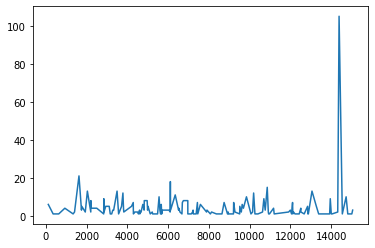

In [18]:
plt.plot(df_bat[~df_bat['retroID'].isin(df_meta['retroID'])]['G'])

<p>For the most part, we're talking about players who have played under 20 total games. We can easily drop these data points and not really affect the overall result.</p>

<h2>Combining the Tensors</h2>

<h3>Catchers</h3>

In [19]:
df_catch.shape[0] + df_field.shape[0] + df_pitch.shape[0]

23591

In [20]:
df_catch

,retroID,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
0,adamb105,1.0,27.0,6,0,0.0,0,0.0,0.0,1.0,0.0,0.0
1,adamb106,0.0,0.0,249,90,12.0,15,7.0,0.0,0.0,0.0,0.0
2,adamd101,3.0,78.0,9,2,0.0,0,1.0,0.0,0.0,0.0,0.0
3,adled101,65.0,1840.0,453,26,4.0,2,8.0,19.0,37.0,16.0,0.0
4,afent001,20.0,613.0,123,5,1.0,3,6.0,0.0,17.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1524,zimmd101,27.0,744.0,150,18,6.0,1,5.0,12.0,10.0,10.0,3.0
1525,zimmj101,298.0,8560.0,2131,150,21.0,26,19.0,84.0,110.0,80.0,4.0
1526,zinta001,0.0,3.0,2,0,0.0,0,0.0,0.0,0.0,0.0,0.0
1527,zunim001,535.0,14489.0,4356,264,21.0,22,39.0,0.0,248.0,98.0,0.0


In [21]:
np.intersect1d(df_catch.columns, df.columns)

array(['CS', 'SB', 'retroID'], dtype=object)

<p>The 'caught stealing' and 'stolen bases' stats appear both offensively and defensively (CS/SB against) for catchers. We need to keep them separate when merging the metadata and we can do so by just adding a prefix to the defensive stats.</p>

In [22]:
df_catch.rename(columns={'CS': 'CS_A', 'SB': 'SB_A'}, inplace=True)

In [23]:
catchers = pd.merge(df_catch, df, how='inner', on=['retroID'])

In [24]:
catchers

,retroID,GS,InnOuts,PO,A,E,DP,PB,WP,SB_A,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,NL
0,adamb105,1.0,27.0,6,0,0.0,0,0.0,0.0,1.0,...,0,0.0,0,5,0.0,0,0,0.0,0.0,0
1,adamb106,0.0,0.0,249,90,12.0,15,7.0,0.0,0.0,...,4,2.0,6,27,0.0,0,3,0.0,0.0,1
2,adamd101,3.0,78.0,9,2,0.0,0,1.0,0.0,0.0,...,0,0.0,1,3,0.0,0,0,0.0,1.0,0
3,adled101,65.0,1840.0,453,26,4.0,2,8.0,19.0,37.0,...,0,0.0,18,80,5.0,2,2,1.0,9.0,1
4,afent001,20.0,613.0,123,5,1.0,3,6.0,0.0,17.0,...,0,0.0,5,32,0.0,0,1,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1524,zimmd101,27.0,744.0,150,18,6.0,1,5.0,12.0,10.0,...,45,25.0,246,678,27.0,13,37,14.0,99.0,1
1525,zimmj101,298.0,8560.0,2131,150,21.0,26,19.0,84.0,110.0,...,1,2.0,78,154,12.0,11,31,4.0,38.0,1
1526,zinta001,0.0,3.0,2,0,0.0,0,0.0,0.0,0.0,...,0,0.0,5,34,0.0,0,0,1.0,0.0,1
1527,zunim001,535.0,14489.0,4356,264,21.0,22,39.0,0.0,248.0,...,2,4.0,138,714,1.0,45,8,11.0,38.0,0


<h3>Pitchers</h3>

In [25]:
np.intersect1d(df_pitch.columns, df.columns)

array(['BB', 'G', 'GIDP', 'H', 'HBP', 'HR', 'IBB', 'R', 'SF', 'SH', 'SO',
       'retroID'], dtype=object)

<p>We have quite a few common columns for pitching data and metadata. We'll do what we did for catching and just add 'A' to the end (for 'against'). Since there are quite a few, we'll define a conversion dictionary ahead of time. Before we do that, we see that we can drop the 'G' (games) column as it should be the same between the tables.</p>

In [26]:
df_without_G = df.drop(columns=['G'])

In [27]:
pitching_data_conversion_dict = {
    'BB': 'BB_A',
    'GIDP': 'GIDP_A',
    'H': 'H_A',
    'HBP': 'HBP_A',
    'HR': 'HR_A',
    'IBB': 'IBB_A',
    'R': 'R_A',
    'SF': 'SF_A',
    'SH': 'SH_A',
    'SO': 'SO_A'
}

In [28]:
df_pitch.rename(columns=pitching_data_conversion_dict, inplace=True)

In [29]:
pitchers = pd.merge(df_pitch, df_without_G, how='inner', on=['retroID'])

In [30]:
pitchers

,retroID,BAOpp,ERA,W,L,G,GS,CG,SHO,SV,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,NL
0,aardd001,0.2574,5.1944,16,18,331,0,0,0,69,...,0,0.0,0,2,0.0,0,1,0.0,0.0,1
1,aased001,0.2508,3.4931,66,60,448,91,22,5,82,...,0,0.0,0,3,0.0,0,0,0.0,0.0,1
2,abadf001,0.2501,4.0733,8,27,363,6,0,0,2,...,0,0.0,0,5,0.0,0,0,0.0,1.0,1
3,abbog001,0.2786,4.3317,62,83,248,206,37,5,0,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0
4,abboj001,0.2804,4.4964,87,108,263,254,31,6,0,...,0,0.0,0,10,0.0,0,3,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7830,zolds101,0.2700,3.6890,43,53,250,93,30,5,8,...,1,0.0,10,52,0.0,1,9,0.0,4.0,0
7831,zubeb101,0.2717,5.3617,43,42,224,65,23,3,6,...,0,0.0,10,66,0.0,0,20,0.0,8.0,0
7832,zumaj001,0.2286,3.4420,13,12,171,0,0,0,5,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0
7833,zuveg101,0.2760,4.1280,32,36,265,31,9,2,40,...,0,1.0,9,39,0.0,0,16,0.0,3.0,1


<h3>Fielders</h3>

In [31]:
np.intersect1d(df_field.columns, df.columns)

array(['retroID'], dtype=object)

<p>We don't need to worry about common columns between the general fielding stats and metadata.</p>

In [32]:
fielders = pd.merge(df_field, df_without_G, how='inner', on=['retroID'])

In [33]:
fielders

,retroID,GS,InnOuts,PO,A,E,DP,weight,height,pos_1B,...,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,NL
0,aardd001,0.0,1011.0,11,29,3.0,2,0.569672,0.60,0,...,0,0.0,0,2,0.0,0,1,0.0,0.0,1
1,aaroh101,2977.0,78414.0,7436,429,144.0,218,0.426230,0.45,0,...,240,73.0,1402,1383,293.0,32,21,121.0,328.0,1
2,aarot101,206.0,6472.0,1317,113,22.0,124,0.467213,0.60,1,...,9,8.0,86,145,3.0,0,9,6.0,36.0,1
3,aased001,91.0,3328.0,67,135,13.0,10,0.467213,0.60,0,...,0,0.0,0,3,0.0,0,0,0.0,0.0,1
4,abada001,4.0,138.0,37,1,1.0,3,0.442623,0.50,1,...,0,1.0,4,5,0.0,0,0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14222,zumaj001,0.0,629.0,7,14,2.0,1,0.569672,0.60,0,...,0,0.0,0,0,0.0,0,0,0.0,0.0,0
14223,zupcb001,198.0,5842.0,483,22,12.0,5,0.590164,0.65,0,...,7,5.0,57,137,3.0,6,20,8.0,15.0,0
14224,zuveg101,31.0,1847.0,45,145,7.0,10,0.487705,0.65,0,...,0,1.0,9,39,0.0,0,16,0.0,3.0,1
14225,zuvep001,136.0,3844.0,267,415,23.0,84,0.397541,0.45,0,...,2,0.0,34,50,1.0,2,18,0.0,8.0,1
